In [ ]:
!pip install gymnasium
!pip install -q swig
!pip install gymnasium[box2d]

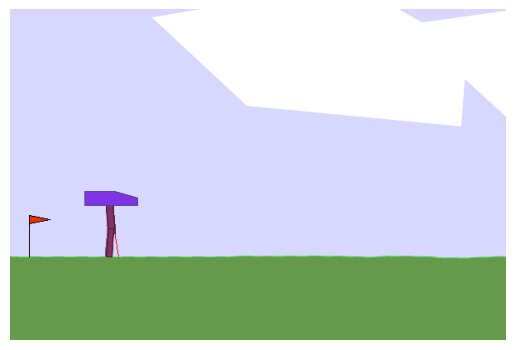

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.axis("off");

In [10]:
import torch
from torch.nn import Module, Linear, ReLU, Tanh, Sequential

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class Policy(Module):

  def __init__(self, hidden_size, obs_size, out_dims):
    super().__init__()
    self.net = Sequential(
        Linear(obs_size, hidden_size),
        ReLU(),
        Linear(hidden_size, hidden_size),
        ReLU(),
        Linear(hidden_size, out_dims))

  def mu(self, state):
    return self.net(state)

  def forward(self, state, epsilon=0.0):
    mu = self.mu(state)
    mu = mu + torch.normal(0, epsilon, mu.size(), device=mu.device)
    action = torch.tanh(mu)
    return action.cpu().numpy()


In [11]:
class QNet(Module):

  def __init__(self, hidden_size, obs_size, out_dims):
    super().__init__()
    self.net = Sequential(
          Linear(obs_size + out_dims, hidden_size),
          ReLU(),
          Linear(hidden_size, hidden_size),
          ReLU(),
          Linear(hidden_size, 1))

  def forward(self, state, action):
    state_action = torch.hstack((state, action))
    return self.net(state_action)

In [12]:
from collections import deque
import random

class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)


In [13]:
def polyak_average(net, target_net, tau=0.01):
  for qp, tp in zip(net.parameters(), target_net.parameters()):
    tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

In [14]:
from gymnasium.wrappers import RecordVideo

def create_gym_environment(name):
  environment = gym.make(name, render_mode="rgb_array")
  environment = RecordVideo(environment, video_folder=f"./{name}_recored_episodes", episode_trigger=lambda x: x % 25 == 0, disable_logger=True)

  return environment

In [27]:
from torch.optim import AdamW
from torch.nn.functional import smooth_l1_loss
from copy import deepcopy
import numpy as np

class DeepDeterministicPolicyGradient():
  def __init__(self, env_name, nets=None, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, tau=0.05,
               loss_fn=smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=600, samples_per_epoch=1024, repeat_action_rate=5):
    self.env = create_gym_environment(env_name)
    self.obs = self.env.reset()

    obs_size = self.env.observation_space.shape[0]
    n_actions = self.env.action_space.shape[0]

    self.q_net = QNet(hidden_size, obs_size, n_actions).to(device) if not nets else nets["q_net"].to(device)
    self.policy = Policy(hidden_size, obs_size, n_actions).to(device) if not nets else nets["policy"].to(device)
    self.q_net_optimizer = optim(self.q_net.parameters(), lr=lr)
    self.policy_optimizer = optim(self.policy.parameters(), lr=lr)

    self.target_q_net = deepcopy(self.q_net)
    self.target_policy = deepcopy(self.policy)

    self.buffer = ReplayBuffer(capacity=capacity)
    self.loss_fn = loss_fn

    self.gamma = gamma
    self.tau = tau
    self.batch_size = batch_size
    self.eps_start = eps_start
    self.eps_end = eps_end
    self.eps_last_episode = eps_last_episode
    self.samples_per_epoch = samples_per_epoch
    self.lr = lr

    self.current_epoch = 1
    self.log = []
    self.returns = []
    self.episode_lengths = []
    self.repeat_action_rate = repeat_action_rate

    while len(self.buffer) < self.samples_per_epoch:
      self.play_episode()

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.0):
      state = self.env.reset()[0]
      state = torch.tensor(state, device=device)
      done = False
      rewards = 0
      epsiode_length = 0

      while not done:
        if policy:
          action = self.policy(state.unsqueeze(0), epsilon=epsilon).squeeze()
        else:
          action = self.env.action_space.sample()

        for _ in range(self.repeat_action_rate):
          next_state, reward, done1, done2, info = self.env.step(action)
          rewards += reward
          epsiode_length += 1
        done = done1 or done2

        next_state, action, reward, done = list(map(lambda x: torch.tensor(x, device=device), [next_state, action, reward, done]))
        exp = (state, action, reward, done, next_state)
        self.buffer.append(exp)

        state = next_state
      return rewards, epsiode_length

  def training_step(self):
      batch_T = self.buffer.sample(self.batch_size)
      batch = list(map(torch.stack, zip(*batch_T)))

      states, actions, rewards, dones, next_states = batch
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)

      action_values = self.q_net(states, actions)
      next_actions = self.target_policy.mu(next_states)
      next_action_values = self.target_q_net(next_states, next_actions)
      next_action_values[dones] = 0.0

      expected_action_values = rewards + self.gamma * next_action_values
      q_loss = self.loss_fn(action_values, expected_action_values)

      self.q_net_optimizer.zero_grad()
      q_loss.backward()
      self.q_net_optimizer.step()

      mu = self.policy.mu(states)
      policy_loss = - self.q_net(states, mu).mean()

      self.policy_optimizer.zero_grad()
      policy_loss.backward()
      self.policy_optimizer.step()

      return q_loss, policy_loss

  def training_epoch_end(self):
      epsilon = max(self.eps_end, self.eps_start - self.current_epoch / self.eps_last_episode)
      last_return, episode_length = self.play_episode(self.policy, epsilon=epsilon)

      polyak_average(self.q_net, self.target_q_net, tau=self.tau)
      polyak_average(self.policy, self.target_policy, tau=self.tau)
      self.current_epoch += 1

      return last_return, episode_length

  def fit(self, n_epoch):
      for epoch in range(n_epoch):
        loss_total = 0
        for _ in range(self.samples_per_epoch//self.batch_size):
          loss = self.training_step()

        last_return, episode_length  = self.training_epoch_end()

        self.returns.append(last_return)
        self.episode_lengths.append(episode_length)
        self.log.append([self.current_epoch, last_return])

        if self.current_epoch % 25 == 0:
          print(f"Epoch: {self.current_epoch}, mean return: {np.mean(self.returns[-10:]):.2f}, " \
            f"mean episode length: {np.mean(self.episode_lengths[-10:])}")

In [ ]:
alg = DeepDeterministicPolicyGradient("BipedalWalker-v3", repeat_action_rate=3, lr=1e-4, eps_start=0.3, eps_end=0.15)
alg.fit(1500)